In [1]:
import praw
import pandas as pd
import re
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import string
from collections import Counter
from statsmodels.stats.proportion import proportions_ztest
#For extra models:
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#from germansentiment import SentimentModel
#from textblob import TextBlob

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # We used this code to gather data



# # Conneting to reddit

# # Reddit API logins
# client_id = "//"  # add your own data
# client_secret = "//" # add your own data
# user_agent = "//" # add your own data

# # Connecting to the reddit API
# reddit = praw.Reddit(client_id=client_id,
#                      client_secret=client_secret,
#                      user_agent=user_agent)

In [3]:
# # Same here



# # Gathering comments from reddit and creating csv files

# # Function for gathering comments from x threads of chosen subreddit y
# def gather_comments(sub, threadnumber = 50):
#     subreddit = reddit.subreddit(sub)
#     data = []
#     for submission in subreddit.hot(limit = threadnumber):
#         submission.comments.replace_more(limit = 0)
#         for comment in submission.comments.list():
#             data.append([submission.title, comment.body])
            
#     df = pd.DataFrame(data, columns=["Thread Title", "Comment"])
#     return df

# # Gatherring comments from the Austrian subreddit and creating csv files
# df_austria = gather_comments("Austria", 200)
# df_austria.to_csv("austria.csv", mode = "a", index = False, header = False)

# # Gatherring comments from the German subreddit and creating csv files
# df_germany = gather_comments("de", 200)
# df_germany.to_csv("germany.csv", mode = "a", index = False, header = False)

# # Gatherring comments from the Swiss subreddit and creating csv files
# df_switzerland = gather_comments("Switzerland", 200)
# df_switzerland.to_csv("switzerland.csv", mode = "a", index = False, header = True)

In [4]:
# Creating pandas DataFrames and dropping duplicates

# Creating a pandas DataFrames for austria
df_austria = pd.read_csv("austria.csv")

# Creating a pandas DataFrames for germany
df_germany = pd.read_csv("germany.csv")

# Creating a pandas DataFrames for switzerland
df_switzerland = pd.read_csv("switzerland.csv")

# Dropping duplicate comments in all DataFrames
df_austria = df_austria.drop_duplicates()
df_germany = df_germany.drop_duplicates()
df_switzerland = df_switzerland.drop_duplicates()

In [5]:
# Removing different symbols that might interfer with the analysis and wordcloud generation

# Function that removes the symbols
def cleanTxt(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text)  # Remove @mentions
    text = re.sub(r"#", "", text)  # Remove the "#"" symbol
    text = re.sub(r"RT[\s]+", "", text)  # Remove "RT"
    text = re.sub(r"https?:\/\/\S+", "", text)  # Remove hyperlinks
    text = re.sub(r":", "", text)  # Remove colons
    return text

# Applying the function
df_austria["Comment"] = df_austria["Comment"].apply(cleanTxt)
df_germany["Comment"] = df_germany["Comment"].apply(cleanTxt)
df_switzerland["Comment"] = df_switzerland["Comment"].apply(cleanTxt)

In [6]:
# Removing emojis and similiars that might interfer with the analysis and wordcloud generation

# Function that removes the emojis and such
def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        u"\U00002500-\U00002BEF"  # Chinese characters
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001F926-\U0001F937"
        u"\U00010000-\U0010FFFF"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200D"
        u"\u23CF"
        u"\u23E9"
        u"\u231A"
        u"\uFE0F"  # Dingbats
        u"\u3030"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', string)

# Applying the function
df_austria["Comment"] = df_austria["Comment"].apply(remove_emoji)
df_switzerland["Comment"] = df_switzerland["Comment"].apply(remove_emoji)
df_germany["Comment"] = df_germany["Comment"].apply(remove_emoji)

In [7]:
# Analyzing the data with twitter Roberta

# Starting a twitter Roberta analysis
roberta_analyzer = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", max_length=512, truncation =True)

# Function that analyzes the comment
def analyze_sentiment_bert(comment):
    return(roberta_analyzer(comment)[0]["label"].upper())

# Applying the function
df_austria["SentimentRoberta"] = df_austria["Comment"].apply(analyze_sentiment_bert)
df_germany["SentimentRoberta"] = df_germany["Comment"].apply(analyze_sentiment_bert)
df_switzerland["SentimentRoberta"] = df_switzerland["Comment"].apply(analyze_sentiment_bert)  

In [8]:
# # Other models we tried and compared





# ##Textblob

# # Function that analyzes the comment
# def analyze_sentiment_textblob(comment):
#     sentiment = TextBlob(comment).sentiment
  
#     if sentiment.polarity > 0:
#         return "POSITIVE"
#     elif sentiment.polarity < 0:
#         return "NEGATIVE"
#     else:
#         return "NEUTRAL"
    
# # Applying the function to all DataFrames
# df_switzerland["SentimentTextblob"] = df_switzerland["Comment"].apply(analyze_sentiment_textblob)




# ##BERT (base)

# # Starting a BERT_base analysis
# bert_base_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", max_length=512, truncation =True)

# #Function that analyzes the comment
# def analyze_sentiment_bertbase(comment):
#     result = bert_base_analyzer(comment)[0]["label"]
    
#     if result in ["5 stars", '4 stars']: 
#         sentiment = 'POSITIVE'
#     elif result == '3 stars':  
#         sentiment = 'NEUTRAL'
#     else:
#         sentiment = 'NEGATIVE'
    
#     return sentiment

# # Applying the function to all DataFrames
# df_austria["SentimentBERTBase"] = df_austria["Comment"].apply(analyze_sentiment_bertbase) 
# df_germany["SentimentBERTBase"] = df_germany["Comment"].apply(analyze_sentiment_bertbase) 
# df_switzerland["SentimentBERTBase"] = df_switzerland["Comment"].apply(analyze_sentiment_bertbase) 




# ##GermanSentiment (BERT-based)

# # Starting a german analysis
# german_analyzer = SentimentModel()

# # Function that analyzes the comment
# def analyze_sentiment_german(comment):
#     result = german_analyzer.predict_sentiment([comment])
#     return result[0].upper()

# # only for austria and germany
# df_austria["SentimentGerman"] = df_austria["Comment"].apply(analyze_sentiment_german)
# df_germany["SentimentGerman"] = df_germany["Comment"].apply(analyze_sentiment_german)




# ## VADER

# # Starting a VADER analysis 
# vader_analyzer = SentimentIntensityAnalyzer()

# # Function that analyzes the comment
# def analyze_sentiment_vader(comment):
#     sentiment_score = vader_analyzer.polarity_scores(comment)
#     compound_score = sentiment_score["compound"] 
    
#     if compound_score >= 0.1:
#         return "POSITIVE"
#     elif compound_score <= -0.1:
#         return "NEGATIVE"
#     else:
#         return "NEUTRAL""] = df_austria["Comment"].apply(analyze_sentiment_vader)
# df_germany["SentimentVADER"] = df_germany["Comment"].apply(analyze_sentiment_vader)
# df_switzerland["SentimentVADER"] = df_switzerland["Comment"].apply(analyze_sentiment_vader)




# ##Roberta Base


# # Yields the same results as the roberta twitter model
# # Starting a Roberta base analysis
# roberta_base_analyzer = pipeline("sentiment-analysis", model="xlm-roberta-base", max_length=512, truncation =True)

# # Function that analyzes the comment
# def analyze_sentiment_roberta_base(comment):
#     return(roberta_base_analyzer(comment)[0].upper())

# # Applying the function
# df_austria["SentimentRobertaBase"] = 

# # Applying the function to all DataFrames
# df_austria["SentimentVADERdf_austria["Comment"].apply(analyze_sentiment_bert)
# df_germany["SentimentRobertaBase"] = df_germany["Comment"].apply(analyze_sentiment_bert)
# df_switzerland["SentimentRobertaBase"] = df_switzerland["Comment"].apply(analyze_sentiment_bert) 

In [9]:
# # We used this to compare models



# # More stats for our analysis (can be used with all the other models)

# # Function to determine the percentage of identical results
# def prec(table, columns):
#     if table.equals(df_austria):
#         print("Stats for Austria:")
#     elif table.equals(df_germany):
#         print("Stats for Germany:")
#     else:
#         print("Stats for Switzerland:")
#     print("--------------------------") 
#     print(f"Comparing {columns[0]} with {columns[1]}:")
#     table.reset_index(drop=True, inplace=True)
#     correct = 0
#     for i in range(len(table[columns[0]])):
#       if table.loc[i, columns[0]] == table.loc[i, columns[1]]:
#         correct += 1    
#     print(f"Similarity: {correct} ({round((correct / len(table[columns[0]])) * 100, 2)}%)")  
    
#     # Checks pos, neg, and neut
#     def prec_unique(sentiment):
#         correct = 0 
#         counter = 0
#         for i in range(len(table[columns[0]])):
#             if table.loc[i, columns[0]] == sentiment and table.loc[i, columns[1]] == sentiment:
#                 correct += 1
#             if table.loc[i, columns[1]] == sentiment:
#                 counter += 1     
#         return correct, round((correct / counter) * 100, 2)

#     for sentiment in ["POSITIVE", "NEGATIVE", "NEUTRAL"]:
#         precision, precision_perc = prec_unique(sentiment)
#         print(f"Precision for {sentiment.lower().capitalize()}: {precision} ({precision_perc}%)")
#     print("\n")

# #Applying the function
# #prec(df_austria, ["SentimentRobertaBase", "SentimentRoberta"])
# #prec(df_germany, ["SentimentRobertaBase", "SentimentRoberta"])
# #prec(df_switzerland, ["SentimentRobertaBase", "SentimentRoberta"])

In [10]:
# General stats for our analysis (can be used with multiple models)

# Function for counting pos, neg, and neu. comments
def stats(table, columns):
    if table.equals(df_austria):
        print("Stats for Austria:")
    elif table.equals(df_germany):
        print("Stats for Germany:")
    else:
        print("Stats for Switzerland:")
    print("--------------------------")        
    table.reset_index(drop=True, inplace=True)
    column_number = 0
    for column in columns:
        count_neg = 0
        count_pos = 0
        count_neu = 0
        column_number += 1
        for i in range(len(table[column])):
            if table.loc[i, column] == "NEGATIVE":
                count_neg +=1
            elif table.loc[i, column] == "POSITIVE":
                count_pos += 1   
            else:
                count_neu += 1
        all = count_pos + count_neg + count_neu           
        print(f"Stats for {column}:\nPositive comments: {count_pos} ({round(count_pos/all,2)}%)\nNeutral comments: " 
              f"{count_neu} ({round(count_neu/all,2)}%)\nNegative comments: {count_neg} ({round(count_neg/all,2)}%)")
        if column_number >= len(columns):  
            print("\n\n")   
        else:
            print("")   
            

# Applying the function
# If you want to analyze more than one model in a country you just need to add the column name in the brackets (e.g. stats(df_austria, ["SentimentRoberta", "SentimentBERTBase"]))
stats(df_austria, ["SentimentRoberta"])
stats(df_germany, ["SentimentRoberta"])
stats(df_switzerland, ["SentimentRoberta"])

Stats for Austria:
--------------------------
Stats for SentimentRoberta:
Positive comments: 2871 (0.1%)
Neutral comments: 8841 (0.3%)
Negative comments: 17354 (0.6%)



Stats for Germany:
--------------------------
Stats for SentimentRoberta:
Positive comments: 3972 (0.08%)
Neutral comments: 15220 (0.31%)
Negative comments: 29141 (0.6%)



Stats for Switzerland:
--------------------------
Stats for SentimentRoberta:
Positive comments: 1673 (0.13%)
Neutral comments: 4527 (0.34%)
Negative comments: 7018 (0.53%)





In [45]:
# Preparing the charts

# Function for drawing a chart to show how the distribution of different comments is
def draw_sentiment_chart(df, sentimenttype, title):
    plt.figure(figsize=(8, 6))
    sns.countplot(x = sentimenttype, data = df, palette = [(229/255, 22/255, 22/255), (27/255, 222/255, 32/255), (166/255, 27/255, 222/255)],
                   order=["NEGATIVE", "POSITIVE", "NEUTRAL"])
    plt.title(title, fontsize=16)
    plt.xlabel("Sentiment", fontsize=14)
    plt.ylabel("Amount", fontsize=14)
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_28548\3630995381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = sentimenttype, data = df, palette = [(229/255, 22/255, 22/255), (27/255, 222/255, 32/255), (166/255, 27/255, 222/255)],


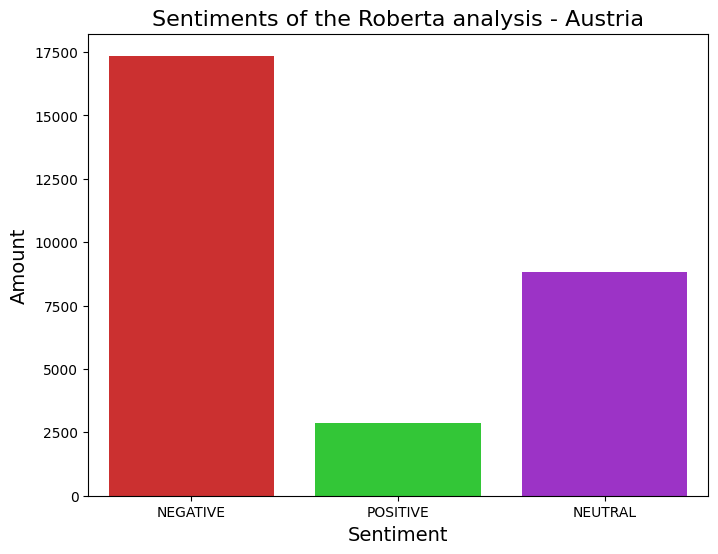

In [46]:
# Charts of different models 

# Applying the function above to Austria
draw_sentiment_chart(df_austria, "SentimentRoberta", "Sentiments of the Roberta analysis - Austria")

C:\Users\Admin\AppData\Local\Temp\ipykernel_28548\3630995381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = sentimenttype, data = df, palette = [(229/255, 22/255, 22/255), (27/255, 222/255, 32/255), (166/255, 27/255, 222/255)],


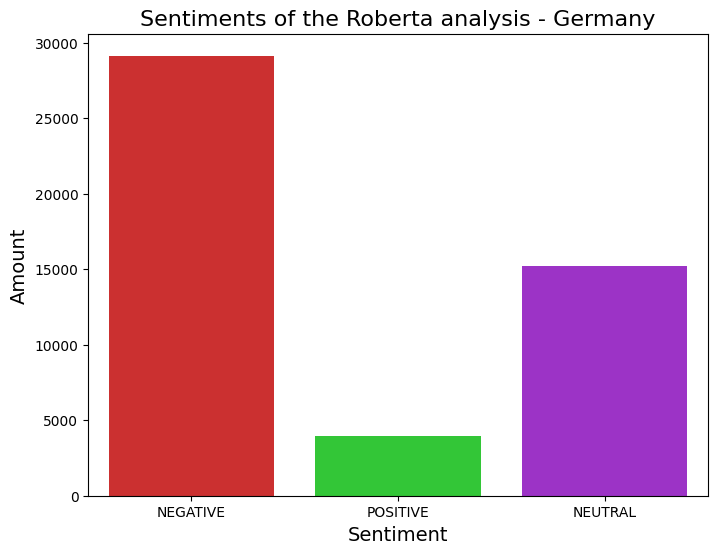

In [47]:
# Charts of different models 

# Applying the function above to Germany
draw_sentiment_chart(df_germany, "SentimentRoberta", "Sentiments of the Roberta analysis - Germany")

C:\Users\Admin\AppData\Local\Temp\ipykernel_28548\3630995381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = sentimenttype, data = df, palette = [(229/255, 22/255, 22/255), (27/255, 222/255, 32/255), (166/255, 27/255, 222/255)],


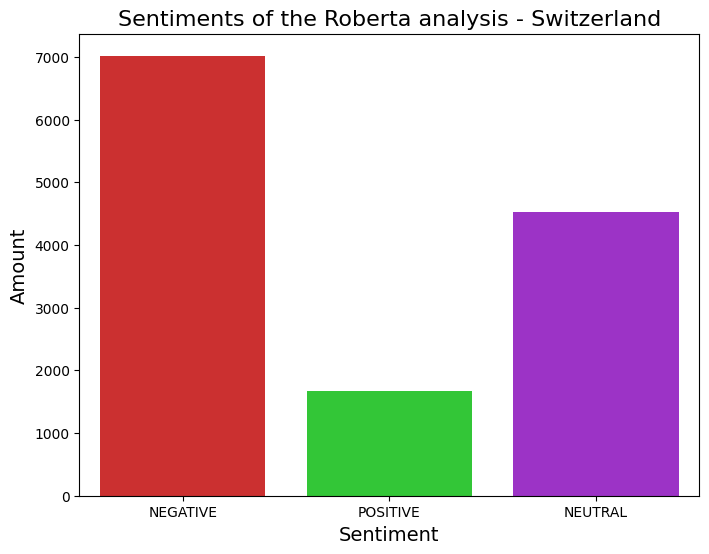

In [48]:
# Charts of different models 

# Applying the function above to Switzerland
draw_sentiment_chart(df_switzerland, "SentimentRoberta", "Sentiments of the Roberta analysis - Switzerland")

In [15]:
#Creating a wordcloud with filtered (stopwords) values 

# Download NLTK stopwords
nltk.download("stopwords")

# Load German and English stopwords due to anglicism and english threads
german_stopwords = set(stopwords.words("german"))
english_stopwords = set(stopwords.words("english"))

# Function for additional stopwords because NLTKs list is lacking
def load_additional_stopwords(file_path):
    with open(file_path, "r", encoding="utf-8") as file: 
        additional_stopwords = set(line.strip() for line in file if line.strip())
    return additional_stopwords

# Define the file path for the additional stopwords
additional_stopwords = load_additional_stopwords("stopwords.txt")

# Combining the stopwords
combined_stopwords = german_stopwords.union(english_stopwords, additional_stopwords)

# Function to remove stopwords from text
def remove_stopwords(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in combined_stopwords]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# Defining a function to find the most common case of a word in our data

# Function for the most common case of a word
def most_common_case(text, word):
    word_count = Counter(text.split())

    variants = []
    for w in word_count:
        if w.lower() == word.lower():
            variants.append(w)

    return Counter(variants).most_common(1)[0][0] 

In [17]:
# Defining a function for counting words with stopwords

# Function for the word frequency
def word_freqeuency(df, sentimenttype = None, sentiment = None, with_return = False, all=False):
    combined_text_all = " ".join(df["Comment"])
    if all:
        filtered_text = remove_stopwords(combined_text_all).lower()
    else:   
        combined_text_initial = " ".join(df[df[sentimenttype] == sentiment]["Comment"]).lower()
        filtered_text = remove_stopwords(combined_text_initial)

    word_freq = Counter(filtered_text.split())
    most_common_words = word_freq.most_common(50)

    if with_return:
        most_common_case_dict = {}
        for word, freq in most_common_words:
            most_common_case_dict[str(most_common_case(combined_text_all, word))] = int(freq)
        return most_common_case_dict
    else:
        total_words = sum(word_freq.values())
        for word, freq in most_common_words:
            print(f"{most_common_case(combined_text_all, word)}: {freq} ({round((freq/total_words)*1000,2)}‰)")

In [18]:
# Word count with stopwords

# Applying the function to Austria
#word_freqeuency(df_austria, all=True)
#word_freqeuency(df_austria, "SentimentRoberta", "NEUTRAL")
#word_freqeuency(df_austria, "SentimentRoberta", "NEGATIVE")
#word_freqeuency(df_austria, "SentimentRoberta", "POSITIVE")

# Applying the function to Germany
#word_freqeuency(df_germany, all=True)
#word_freqeuency(df_germany, "SentimentRoberta", "NEGATIVE")
#word_freqeuency(df_germany, "SentimentRoberta", "NEUTRAL")
#word_freqeuenze(df_germany, "SentimentRoberta", "POSITIVE")

# Applying the function to Switzerland
#word_freqeuency(df_switzerland, all=True)
#word_freqeuency(df_switzerland, "SentimentRoberta", "NEGATIVE")
#word_freqeuency(df_switzerland, "SentimentRoberta", "NEUTRAL")
#word_freqeuency(df_switzerland, "SentimentRoberta", "POSITIVE")

In [76]:
# Defining a function for the wordcloud

# Function for individual wordclouds
def generate_wordcloud(df, sentimenttype, sentiment):
    
    most_common_words = word_freqeuency(df, sentimenttype, sentiment, with_return=True)
    print(most_common_words)
    wordcloud = WordCloud(width = 1920, height = 1080, background_color = "black", 
                            colormap="Purples", max_words=50).generate_from_frequencies(most_common_words) #YlOrBr
    
    plt.figure(figsize = (8, 6))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud for {sentiment} Sentiment", fontsize=16)
    plt.show()

{'Danke': 363, 'super': 99, 'Österreich': 77, 'FPÖ': 71, 'schön': 68, 'ÖVP': 67, 'Recht': 65, 'Jahre': 65, 'geil': 53, 'beste': 52, 'Leben': 52, 'Kickl': 49, 'sicher': 49, 'Neos': 46, 'Glück': 43, 'Froh': 42, 'Land': 38, 'Cool': 36, 'Wien': 35, 'Job': 35, 'arbeit': 34, 'Spaß': 34, 'passt': 34, 'toll': 29, 'hoffe': 29, 'Geld': 28, 'SPÖ': 28, 'lustig': 28, 'Kinder': 28, 'kurz': 27, 'wichtig': 26, 'liebe': 26, 'Partei': 25, 'Regierung': 25, 'empfehlen': 25, 'Welt': 24, 'Deutschland': 24, 'Thanks': 23, 'Bild': 23, 'Babler': 21, 'de': 21, 'zufrieden': 21, 'spannend': 20, 'Woche': 20, 'Lachen': 20, 'sinn': 20, 'hilft': 20, 'Hoffentlich': 19, 'Wow': 19, 'Politik': 19}


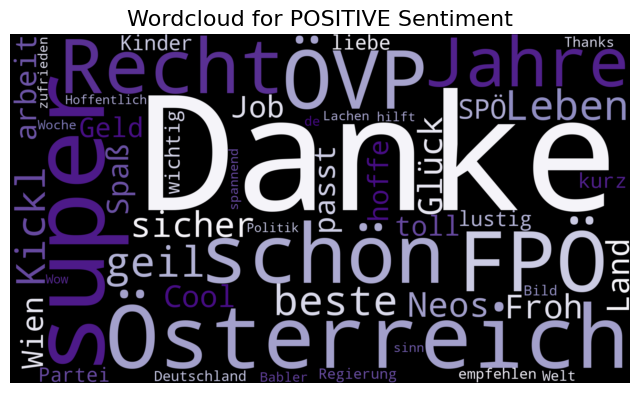

{'FPÖ': 2065, 'ÖVP': 1867, 'SPÖ': 1488, 'Neos': 1152, 'Österreich': 1059, 'Partei': 815, 'Kickl': 788, 'Problem': 725, 'Geld': 714, 'Regierung': 658, 'Jahre': 639, 'Land': 582, 'sicher': 560, 'Parteien': 549, 'Leben': 547, 'Recht': 512, 'wählen': 490, 'Babler': 486, 'Politik': 458, 'steuern': 444, 'Wähler': 419, 'Schuld': 416, 'Meinung': 405, 'EU': 349, 'arbeit': 340, 'gewählt': 335, 'Wahl': 330, 'Kinder': 327, 'Demokratie': 326, 'Welt': 324, 'Staat': 312, 'kurz': 307, 'Grünen': 301, 'pension': 297, 'Probleme': 287, 'Job': 271, 'Nehammer': 265, 'falsch': 262, 'Neuwahlen': 253, 'Koalition': 250, 'schwer': 249, 'Mehrheit': 242, 'Medien': 239, 'Wien': 238, 'ehrlich': 236, 'Wirtschaft': 236, 'Leuten': 232, 'reichen': 231, 'bevölkerung': 231, 'Kanzler': 230}


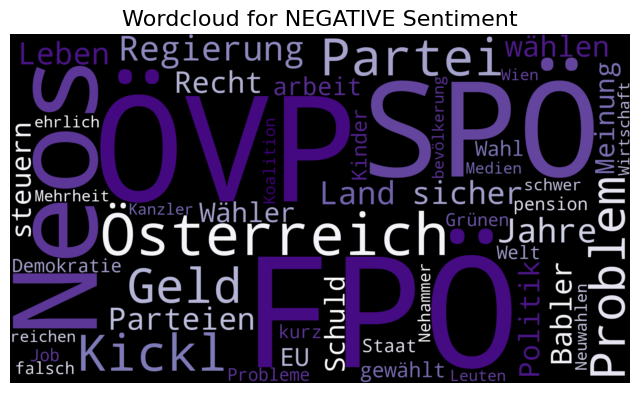

{'FPÖ': 436, 'ÖVP': 385, 'Österreich': 342, 'SPÖ': 287, 'Geld': 269, 'Jahre': 246, 'Partei': 235, 'sicher': 220, 'Neos': 215, 'Leben': 199, 'Problem': 187, 'Recht': 164, 'Parteien': 162, 'steuern': 157, 'Regierung': 153, 'Meinung': 150, 'Kickl': 143, 'Land': 139, 'arbeit': 133, 'Politik': 130, 'Unternehmen': 121, 'Wien': 118, 'Staat': 105, 'Wirtschaft': 101, 'Wahl': 99, 'Mehrheit': 98, 'pension': 97, 'Demokratie': 96, 'Kinder': 95, 'kurz': 94, 'bevölkerung': 93, 'wählen': 92, 'Eltern': 92, 'Kosten': 92, 'Grünen': 90, 'Welt': 90, 'Woche': 90, 'Euro': 89, 'Babler': 88, 'Job': 85, 'wichtig': 84, 'Deutschland': 84, 'Kind': 84, 'gewählt': 82, 'Steuer': 79, 'System': 77, 'stimmen': 76, 'Probleme': 75, 'früher': 75, 'Strom': 75}


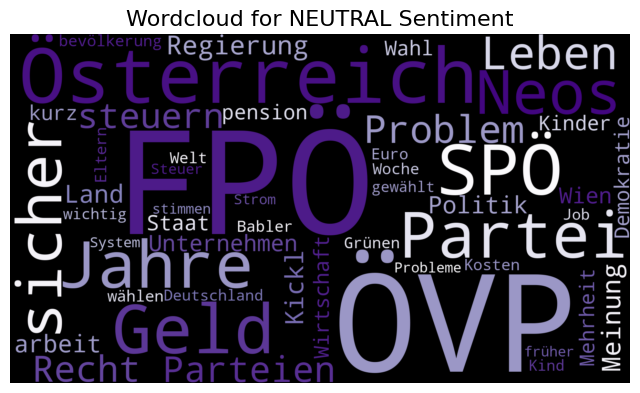

In [77]:
# Applying the function 
for sentiment in ["POSITIVE", "NEGATIVE", "NEUTRAL"]:
    generate_wordcloud(df_austria, "SentimentRoberta", sentiment)

{'danke': 338, 'Schön': 132, 'super': 115, 'Recht': 79, 'geil': 72, 'Deutschland': 71, 'Jahre': 69, 'Idee': 58, 'Cool': 56, 'Spaß': 55, 'Geld': 54, 'beste': 52, 'AfD': 51, 'toll': 48, 'Glück': 46, 'Arbeit': 46, 'Leben': 43, 'FDP': 43, 'Artikel': 43, 'Hoffe': 41, 'Grünen': 40, 'sicher': 40, 'froh': 40, 'Liebe': 37, 'CDU': 36, 'Habeck': 35, 'bestimmt': 34, 'Merz': 33, 'Welt': 33, 'SPD': 32, 'raus': 32, 'Hoffentlich': 31, 'Wow': 31, 'lustig': 30, 'Land': 29, 'Partei': 29, 'Auto': 29, 'Söder': 28, 'Lindner': 27, 'stimme': 27, 'passt': 27, 'Frauen': 26, 'wählen': 26, 'Sinn': 26, 'wahl': 26, 'total': 25, 'verdient': 25, 'deutsche': 25, 'grün': 25, 'Trump': 25}


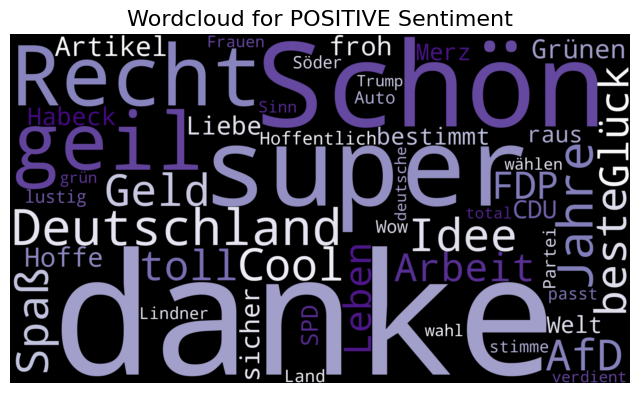

{'Deutschland': 1581, 'AfD': 1517, 'Problem': 1460, 'Geld': 1246, 'Jahre': 950, 'Partei': 877, 'FDP': 871, 'Recht': 814, 'Land': 804, 'CDU': 777, 'Grünen': 728, 'Leben': 724, 'USA': 703, 'sicher': 690, 'Trump': 622, 'probleme': 610, 'Frauen': 592, 'Meinung': 592, 'Politik': 579, 'Parteien': 568, 'Artikel': 551, 'Welt': 549, 'SPD': 546, 'staat': 526, 'wählen': 522, 'falsch': 518, 'Arbeit': 511, 'Regierung': 500, 'feuerwerk': 474, 'Russland': 468, 'deutsche': 446, 'Merz': 445, 'EU': 438, 'Unternehmen': 433, 'deutschen': 432, 'Union': 432, 'Politiker': 429, 'Gesellschaft': 426, 'Polizei': 420, 'Kosten': 420, 'Frau': 395, 'stark': 369, 'Männer': 369, 'System': 364, 'SCHEIẞE': 364, 'Auto': 363, 'China': 362, 'Medien': 361, 'Lindner': 356, 'raus': 355}


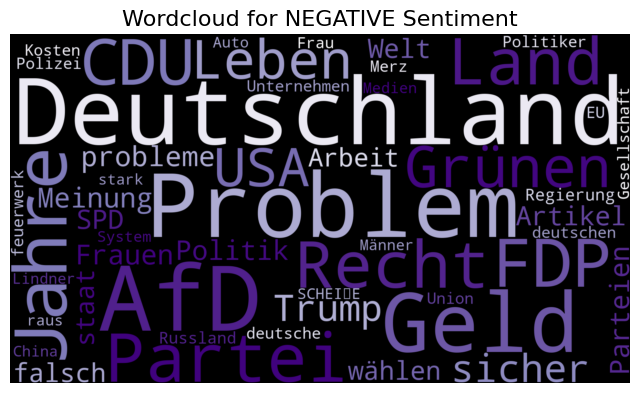

{'Deutschland': 709, 'Geld': 602, 'Frauen': 423, 'Jahre': 409, 'Problem': 391, 'Artikel': 352, 'Recht': 338, 'AfD': 333, 'FDP': 309, 'Partei': 302, 'Unternehmen': 296, 'Euro': 292, 'sicher': 286, 'Leben': 279, 'Land': 274, 'staat': 256, 'Arbeit': 253, 'Männer': 248, 'Grünen': 246, 'Kosten': 239, 'deutschen': 231, 'Gesellschaft': 214, 'deutsche': 213, 'Frau': 212, 'Auto': 211, 'USA': 206, 'Parteien': 201, 'CDU': 199, 'Meinung': 198, 'Politik': 194, 'Daten': 188, 'Art': 176, 'probleme': 175, 'Kinder': 169, 'wahl': 168, 'Milliarden': 164, 'SPD': 163, 'Welt': 160, 'Steuern': 160, 'Regierung': 158, 'Autos': 156, 'Millionen': 155, 'Wirtschaft': 155, 'Bevölkerung': 153, 'Union': 152, 'Aussage': 152, 'EU': 151, 'System': 150, 'Musk': 147, 'Quelle': 146}


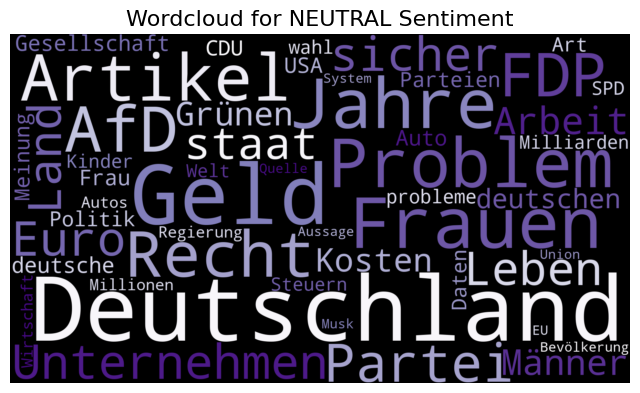

In [78]:
# Applying the function 
for sentiment in ["POSITIVE", "NEGATIVE", "NEUTRAL"]:
    generate_wordcloud(df_germany, "SentimentRoberta", sentiment)

{'good': 248, 'Thank': 125, 'Thanks': 117, 'great': 112, 'Swiss': 102, 'time': 95, 'Switzerland': 92, 'work': 86, 'best': 82, 'years': 75, 'well': 73, 'job': 72, 'love': 53, 'happy': 51, 'Nice': 49, 'right': 43, 'pretty': 42, 'country': 40, 'agree': 39, 'life': 39, 'new': 37, 'experience': 37, 'free': 36, 'home': 35, 'German': 35, 'feel': 34, 'US': 33, 'pay': 33, 'Day': 33, 'quality': 33, 'money': 33, 'local': 32, 'found': 29, 'Hope': 29, 'place': 28, 'Migros': 28, 'buy': 27, 'French': 27, 'luck': 26, 'able': 26, 'fun': 26, 'Works': 25, 'least': 25, 'high': 25, 'fine': 24, 'worth': 24, 'amazing': 24, 'big': 24, 'Zurich': 24, 'live': 24}


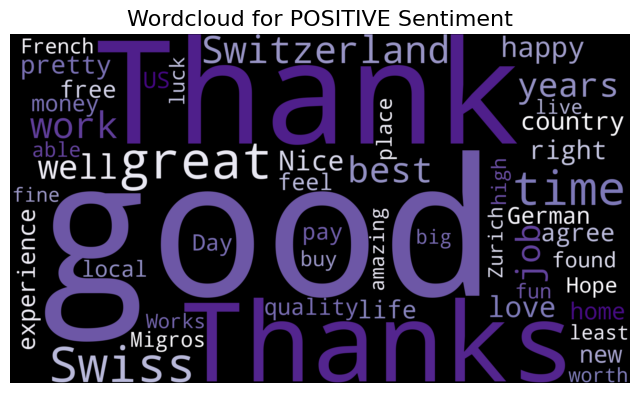

{'Switzerland': 925, 'Swiss': 881, 'work': 732, 'time': 729, 'years': 567, 'pay': 538, 'job': 538, 'good': 534, 'money': 469, 'well': 435, 'country': 370, 'US': 364, 'car': 361, 'problem': 336, 'right': 329, 'bad': 325, 'company': 299, 'live': 298, 'home': 283, 'feel': 278, 'Day': 272, 'life': 267, 'new': 265, 'German': 259, 'family': 251, 'companies': 245, 'market': 244, 'place': 238, 'experience': 232, 'least': 232, 'countries': 232, 'language': 228, 'buy': 227, 'high': 224, 'Migros': 214, 'best': 211, 'insurance': 204, 'expensive': 203, 'free': 203, 'big': 202, 'working': 199, 'jobs': 199, 'leave': 194, 'last': 194, 'cost': 192, 'hard': 190, 'World': 188, 'either': 187, 'public': 187, 'keep': 186}


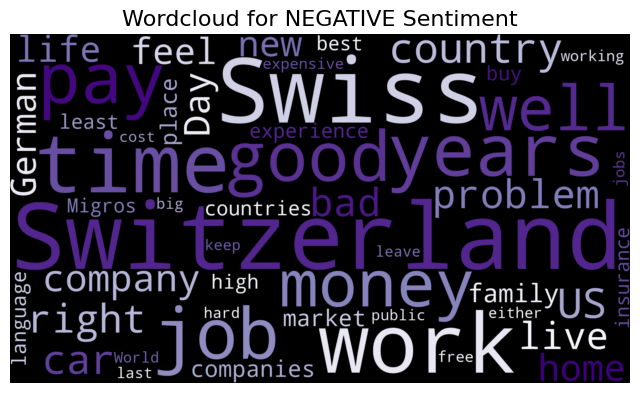

{'time': 239, 'Swiss': 231, 'Switzerland': 221, 'work': 216, 'pay': 186, 'years': 162, 'well': 153, 'job': 150, 'good': 128, 'new': 116, 'right': 115, 'CHF': 115, 'car': 113, 'money': 112, 'free': 111, 'company': 109, 'German': 105, 'buy': 105, 'Day': 101, 'insurance': 99, 'days': 88, 'next': 85, 'home': 84, 'tax': 84, 'live': 84, 'train': 78, 'least': 76, 'months': 73, 'paid': 72, 'place': 70, 'help': 69, 'Number': 69, 'country': 69, 'contract': 69, 'price': 68, 'means': 68, 'last': 66, 'send': 66, 'cost': 66, 'Migros': 65, 'AI': 65, 'month': 64, 'experience': 64, 'local': 63, 'working': 62, 'water': 61, 'office': 60, 'French': 60, 'costs': 60, 'sign': 59}


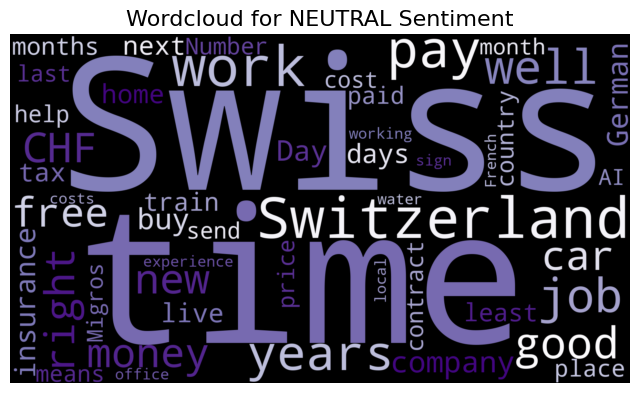

In [79]:
# Applying the function 
for sentiment in ["POSITIVE", "NEGATIVE", "NEUTRAL"]:
    generate_wordcloud(df_switzerland, "SentimentRoberta", sentiment)

In [23]:
# Preparing data for z-test

# Function for the preparation
def count_pos(df, column):
    pos_count = 0
    for sentiment in df[column]:
        if sentiment == "NEGATIVE":
            pos_count += 1

    return pos_count

In [24]:
# Z-test for proportions

# Applying the function 
swiss_pos = count_pos(df_switzerland, "SentimentRoberta")
austria_pos = count_pos(df_austria, "SentimentRoberta")
germany_pos = count_pos(df_germany, "SentimentRoberta")

# Executing the Z-Test and printing the results
z_stat, p_value = proportions_ztest([swiss_pos, austria_pos], [len(df_switzerland["SentimentRoberta"]), len(df_austria["SentimentRoberta"])])
print(f"Switzerland vs Austria: Z-stat: {z_stat}, p-value: {p_value}")
z_stat, p_value = proportions_ztest([swiss_pos, germany_pos], [len(df_switzerland["SentimentRoberta"]), len(df_germany["SentimentRoberta"])])
print(f"Switzerland vs Germany: Z-stat: {z_stat}, p-value: {p_value}")
z_stat, p_value = proportions_ztest([austria_pos, germany_pos], [len(df_austria["SentimentRoberta"]), len(df_germany["SentimentRoberta"])])
print(f"Austria vs Germany: Z-stat: {z_stat}, p-value: {p_value}")


Switzerland vs Austria: Z-stat: -12.753469319482758, p-value: 2.9817415027074325e-37
Switzerland vs Germany: Z-stat: -14.896008771468818, p-value: 3.498639905026587e-50
Austria vs Germany: Z-stat: -1.6137823024457294, p-value: 0.10657465457608753
